In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read all words
words = open('../hafta12/assets/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Eski ML 80-10-10 70-20-10 70-15-15  (1k-100k)
# Deep Learning 10million -> 99% 0.5% 0.5% -> 100k 
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [61]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 / np.sqrt(n_embd * block_size)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0



parameters = [C, W1,b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [69]:
import numpy as np
1 / np.sqrt(n_embd * block_size)

0.18257418583505536

In [65]:
# Mini-batch GD
max_steps = 200000
batch_size = 32

lossi = []
for i in range(max_steps):
    # construct mini-batch
    ixs = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    mini_batch = Xtr[ixs,:]
    mini_batch_y = Ytr[ixs]
    
    # forward pass
    emb = C[mini_batch]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@ W1+b1 #pre-activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_y)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    l_r = 0.01 if i < 1e5 else 0.01
    for p in parameters:
        p.data += - l_r* p.grad
    
    if i% 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3028
  10000/ 200000: 2.3662
  20000/ 200000: 2.3604
  30000/ 200000: 2.1589
  40000/ 200000: 2.1337
  50000/ 200000: 2.0997
  60000/ 200000: 2.1754
  70000/ 200000: 2.3686
  80000/ 200000: 2.1158
  90000/ 200000: 2.1806
 100000/ 200000: 1.7467
 110000/ 200000: 2.0525
 120000/ 200000: 2.2811
 130000/ 200000: 2.2439
 140000/ 200000: 2.4117
 150000/ 200000: 2.3709
 160000/ 200000: 1.8021
 170000/ 200000: 2.3392
 180000/ 200000: 2.2442
 190000/ 200000: 1.8331


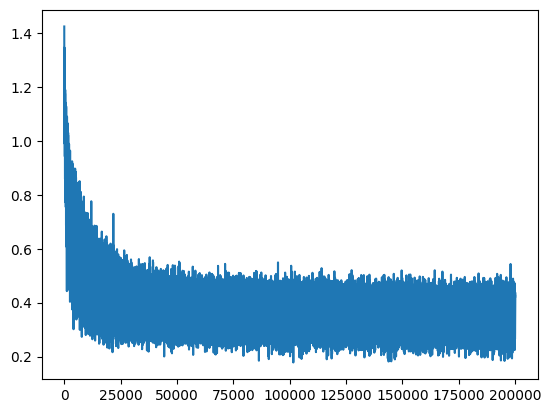

In [13]:
plt.plot(lossi);

In [66]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev), #validation set development set
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1+b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.096475601196289
val 2.13328218460083


In [ ]:
# 2.26 2.27
# after small W1 b1: 2.09 2.13

In [16]:
# negative log likelihood
# abc -> y  1/27
- torch.tensor(1/27.0).log()

tensor(3.2958)

In [29]:
## 4-dim example 
# 
logits = torch.tensor([0., 0., 0., 0.])
probs = torch.softmax(logits,dim=0) # e^y1 / (e^y1+e^y2+e^y3+e^y4)
loss = -probs[2].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

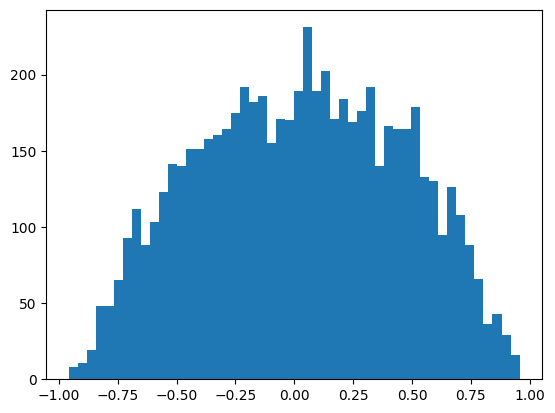

In [58]:
# saturated
plt.hist(h.view(-1).tolist(),50);

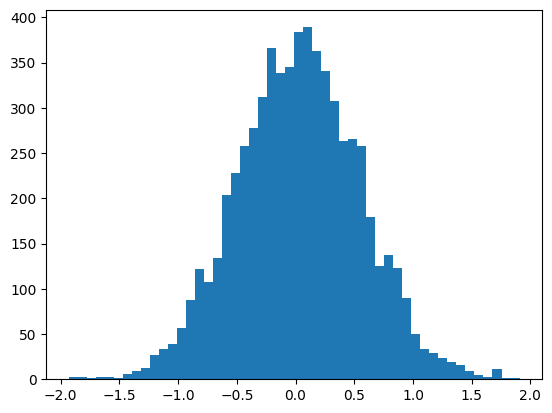

In [59]:
plt.hist(hpreact.view(-1).tolist(),50);

In [51]:
torch.tanh(torch.tensor(3.))

tensor(0.9951)

In [53]:
h.shape

torch.Size([32, 200])

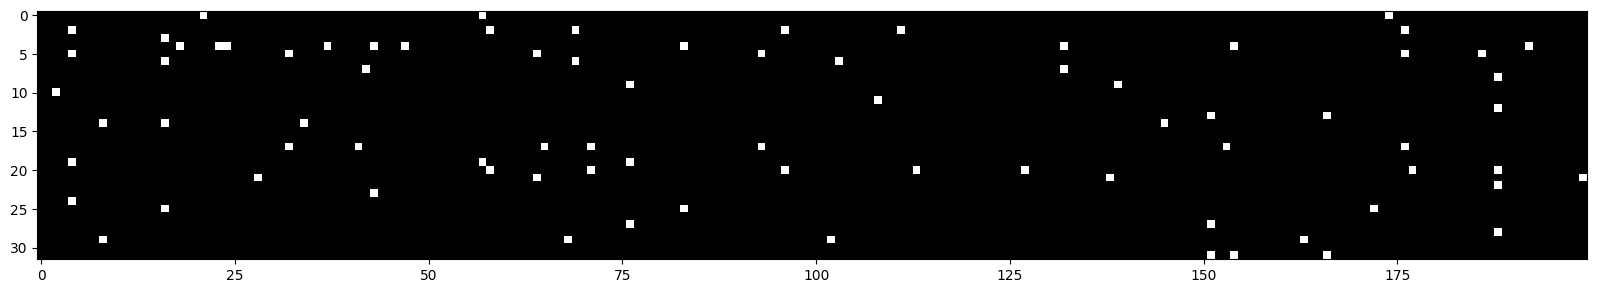

In [63]:
# white dots denote the value of |h|>0.99 which means it is in one of the saturated regions
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

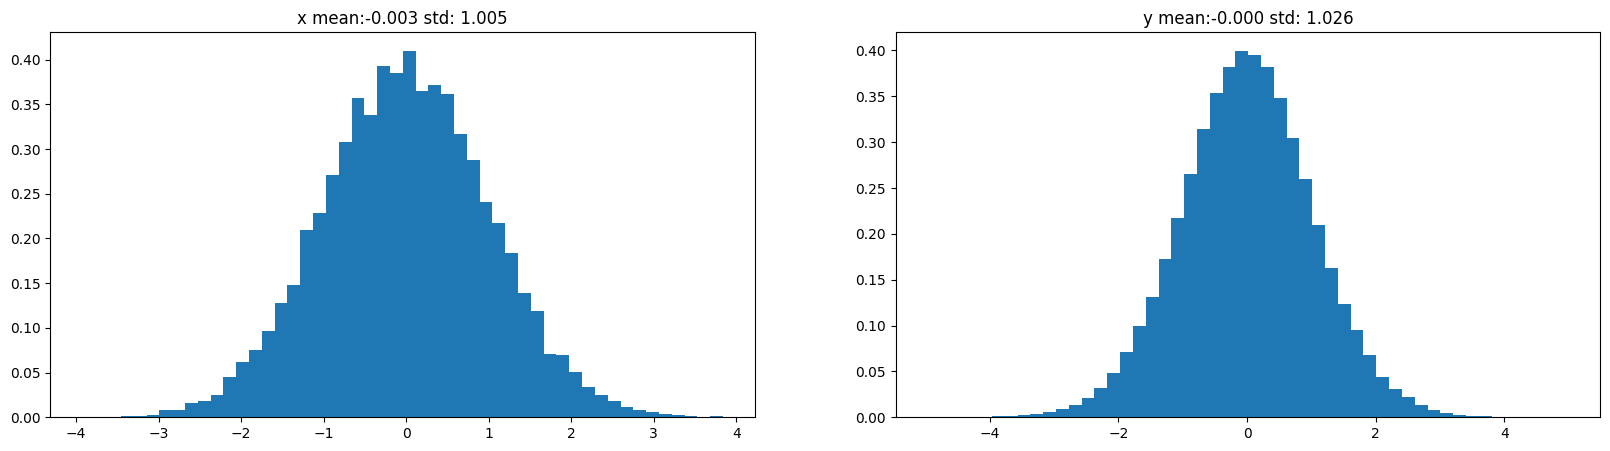

In [73]:
x = torch.randn(1000,20) # Standard Normal distribution mu=0 , std=1
w = torch.randn(20,200) / np.sqrt(20) # Standard Normal distribution mu=0 , std=1
y = x @ w 

plt.figure(figsize=(20,5))
ax = plt.subplot(121)
ax.set_title(f'x mean:{x.mean():.3f} std: {x.std():.3f}')
plt.hist(x.view(-1).tolist(),50,density=True);

ax = plt.subplot(122)
ax.set_title(f'y mean:{y.mean():.3f} std: {y.std():.3f}')
plt.hist(y.view(-1).tolist(),50,density=True);

3.1622776601683795